<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Introdução

O Dask é uma biblioteca de computação paralela que dimensiona o ecossistema existente do Python. Este tutorial apresentará o Dask e a análise de dados paralelos de maneira mais geral, com o objetivo de apresentar as possibilidades e comandos deste recurso.

O Dask pode ser redimensionado para o laptop e em seguida do laptop até um cluster. Aqui, usaremos um ambiente que você configura no seu laptop para analisar conjuntos de dados de tamanho médio em paralelo localmente.

# 0. OVERVIEW

O Dask fornece execução paralela de múltiplos núcleos diferentes e distribuída em conjuntos de dados maiores que a memória do computador, permitindo o processamento de dados em larga escala.

Podemos pensar em Dask em um nível mais alto, bem como em um nível mais baixo.

- __Opções de alto nível__: o Dask fornece opções de Array, Bag e DataFrame de alto nível que imitam o NumPy, listas e Pandas, mas podem operar em paralelo, em conjuntos de dados que não se encaixam na memória. As opções de alto nível do Dask são alternativas ao NumPy e Pandas para grandes conjuntos de dados.

- __Planejadores de baixo nível__: o Dask fornece planejadores de tarefas gráficas que são executadas de forma paralela e dinâmica. Esses mecanismos de execução alimentam as coleções de alto nível mencionadas acima, mas também podem alimentar tarefas de trabalho personalizadas e definidas pelo usuário. Esses planejadores têm baixa latência (cerca de 1ms) e trabalham muito para executar cálculos em uma pequena região de memória. Os escalonadores do Dask são uma alternativa para o uso direto de bibliotecas de `threading` ou multiprocessamento em casos complexos ou outros sistemas de agendamento de tarefas como o `Luigi` or `IPython parallel`.

Usuários diferentes operam em níveis diferentes, mas é útil entender os dois, sendo que os casos de uso do Dask fornecem vários fluxos de trabalho de amostra em que o Dask deve ser um bom ajuste. Para saber mais [clique aqui](http://docs.dask.org/en/latest/use-cases.html)

## Preparação

inicialmente, é necessário clonar este repositório

- git clone http://github.com/dask/dask-tutorial

O arquivo incluso na pasta desta aula `environment.yml` contém uma lista de todos os pacotes necessários para executar este tutorial. Para instalá-los usando conda, você seve dorar os seguintes códigos

- conda env create environment.yml
- conda ativar dask-tutorial

Faça isso antes de executar este notebook. Por fim, execute o seguinte script para baixar e criar dados para análise.


In [1]:
# !pip install graphviz

In [2]:
# in directory dask-tutorial/
# this takes a little while
%run prep.py

** Finished! **


### Literatura de apoio

*  Referências
    *  Para a documentação clique em [Documentation](https://dask.pydata.org/en/latest/)
    *  Opções de código clique em [Code](https://github.com/dask/dask/)
    *  Opção para [Blog](http://matthewrocklin.com/blog/)
*  Para pedir ajuda
    *   [dask](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow
    *   [github issues](https://github.com/dask/dask/issues/new) for bug reports and feature requests
    *   [gitter](https://gitter.im/dask/dask) for quasi-realtime conversation
    

## Estrutura do Tutorial

Cada seção é um caderno Jupyter, onde há uma mistura de texto, código e exercícios.

Em caso de utilização do Jupyterlab, é semelhante ao Notebook Jupyter. Em caso da não utilização do Notebook, a introdução rápida é:

1. Existem dois modos: comando e edição
2. No modo de comando, pressione `Enter` para editar uma célula (como essa célula de marcação)
3. No modo de edição, pressione `Esc` para mudar para o modo de comando
4. Pressione `shift + enter` para executar uma célula e passar para a próxima célula.

A barra de ferramentas possui comandos para executar, converter e criar células.

O layout do tutorial está constituído em:

- Foundations: uma explicação do que é o Dask, como ele funciona e como usar primitivos de baixo nível para configurar cálculos. Usuários casuais podem querer pular esta seção, embora consideremos que é um conhecimento útil para todos os usuários.

- Distributed: informações sobre a execução do Dask no planejador distribuído, que permite escalonamento para configurações distribuídas e monitoramento aprimorado das operações da tarefa. O agendador distribuído é geralmente o mecanismo recomendado para executar tarefas, mesmo em estações de trabalho ou laptops.

- Coleções: abstrações convenientes que dão uma sensação familiar ao big data

    - bag: os iteradores Python com um paradigma funcional, como os encontrados em func / iter-tools e toolz - generalizam listas / geradores para big data; isso parecerá muito familiar aos usuários do [RDD] do PySpark (http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD)
    - array: dados numéricos multidimensionais massivos, com funcionalidade Numpy
    - dataframes: dados tabulares maciços, com funcionalidade Pandas
    
Considerando que há uma grande quantidade de informações na documentação apresentada acima, aqui temos como objetivo dar dicas práticas para auxiliar a compreensão e aplicação do Dask em situações cotidianas. Isso significa que não é possível esperar que todas as características do Dask sejam abordadas, mas os exemplos são semelhantes aos tipos de fluxos de trabalho necessários.

## Exercício: Imprimir `Olá, mundo!`

Cada notebook terá exercícios para resolução, em uma célula em branco ou parcialmente concluída, seguida por uma célula "mágica" que carregará a solução. Por exemplo


Imprima o texto "Olá, mundo!"

In [3]:
# %load solutions/00-hello-world.py
print("Hello, world!")

Hello, world!


# 1. DASK DELAYED

# Paralelizando códigos com `dask.delayed`

Nesta seção, faremos o paralelismo de um código de estilo simples, for-loop, com o Dask e o `dask.delayed`. Frequentemente, esta é a única função que necessária para converter funções para uso com o Dask.

Esta é uma maneira simples de usar `dask` para paralelizar bases de código existentes ou construir [sistemas complexos](http://matthewrocklin.com/blog/work/2018/02/09/credit-models-with-dask). Isso também ajudará a desenvolver um entendimento para seções posteriores.

## Noções básicas

Primeiro faremos algumas funções simples, `inc` e` add`, combinadas com o `sleep` por um tempo para simular o trabalho. Vamos então executar essas funções normalmente, com a medição do tempo.

Na próxima seção, vamos paralelizar este código.

In [9]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

Cronometramos a execução deste código normal usando `%% time`, que é uma função especial do Notebook Jupyter.

In [10]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

Wall time: 3 s


### Paralelização com o decorador `dask.delayed`

Essas duas chamadas de incremento "poderiam" ser chamadas em paralelo, porque são totalmente independentes de uma outra.

Vamos transformar as funções `inc` e` add` usando a função `dask.delayed`. Quando chamamos a versão atrasada passando os argumentos, exatamente como antes, a função original ainda não é chamada - e é por isso que a execução da célula termina muito rapidamente.

Em vez disso, é feito um "atraso", que controla a função a ser chamada e os argumentos a serem passados para ela.

In [11]:
from dask import delayed

In [12]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

Wall time: 0 ns


Isso rodou imediatamente, já que nada realmente aconteceu ainda.

Para obter o resultado, chame `compute`. Observe que isso é executado mais rápido que o código original.

In [13]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

Wall time: 2 s


5

## O que exatamente aconteceu?

O objeto `z` é um objeto` Delayed` preguiçoso. Este objeto contém tudo o que precisamos para calcular o resultado final, incluindo referências a todas as funções que são necessárias e suas entradas e relações entre si. Nós podemos avaliar o resultado com `.compute ()` como acima ou nós podemos visualizar o gráfico da tarefa para este valor com `.visualize ()`.

In [14]:
z

Delayed('add-60151e59-7176-4ad1-a161-e591e9cf88d0')

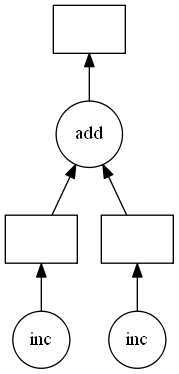

In [15]:
# Look at the task graph for `z`
z.visualize()

Observe que isso inclui os nomes das funções de antes e o fluxo lógico das saídas das funções `inc` para as entradas de` add`.

### Algumas questões a considerar:

- Por que nós fomos de 3s para 2s? Por que não conseguimos paralelizar até 1s?
- O que teria acontecido se as funções inc e add não incluíssem o `sleep (1)`? Ask ainda seria capaz de acelerar este código?
- E se tivermos várias saídas ou também quisermos ter acesso a x ou y?

## Exercício: Paralelizar um loop for

Loops `for` são uma das coisas mais comuns que queremos paralelizar. Use `dask.delayed` em` inc` e `sum` para paralelizar o cálculo abaixo:

In [17]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [18]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

Wall time: 8 s


In [23]:
total


Delayed('sum-471e8cf7-a9c9-4523-be93-58c092e30cd6')

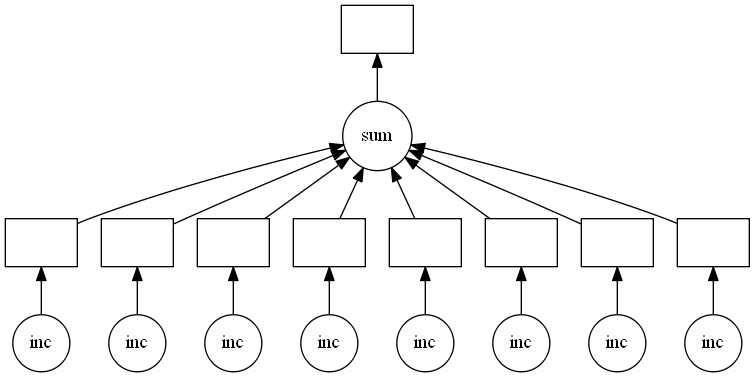

In [22]:
total.visualize()

In [20]:
%%time
# Your parallel code here...

Wall time: 0 ns


In [21]:
%%time
# %load solutions/01-delayed-loop.py
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-471e8cf7-a9c9-4523-be93-58c092e30cd6')
After computing : 44
Wall time: 1.01 s


Como as visualizações gráficas se comparam com a solução dada, em comparação com uma versão com a função `sum` usada diretamente em vez de envolvida com` delay`? Você pode explicar a última versão? Você pode encontrar o resultado da seguinte expressão iluminando

```python
delayed (inc) (1) + delayed (inc) (2)


## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [14]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [15]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
Wall time: 10 s


In [16]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

Wall time: 0 ns


In [17]:
# %load solutions/01-delayed-control-flow.py
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [18]:
%time total.compute()

Wall time: 2.01 s


90

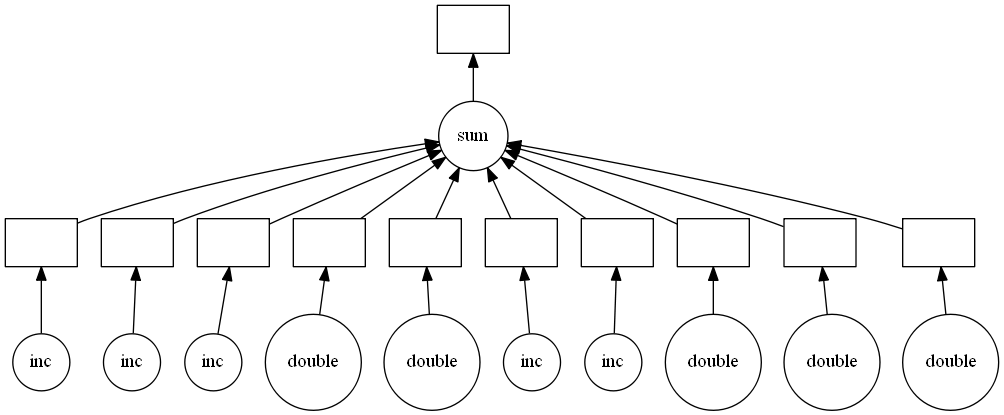

In [19]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

### Prep data

First, run this code to prep some data, if you have not already done so.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [20]:
%run prep.py

** Finished! **


### Inspect data

In [21]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### Read one file with `pandas.read_csv` and compute mean departure delay

In [22]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [23]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [24]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [25]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [26]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [27]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 7.99 s


In [28]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [29]:
from dask import compute

In [30]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 7.21 s


In [31]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [32]:
%%time
# your code here

Wall time: 0 ns


If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [33]:
# %load solutions/01-delayed-groupby.py
# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [34]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?